<a href="https://colab.research.google.com/github/elcintimurcakmak/A-B-Testing/blob/main/eniac_A_B_testing_with_four_button_versions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [141]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.


In [116]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

# Hypothesis testing: Chi-Square Test within the Eniac case study

In this notebook we perform a chi-square test with the data from the Eniac case study, applying a post-hoc correction to perform pairwise tests and find the true winner.

**State the Null Hypothesis and the Alternative Hypothesis.**

$H_0$: All four versions perform the same / have the CTR       
$H_A$: One or more version have a significantly different CTR

**Select an appropriate significance level alpha ($\alpha$).**

It was decided that a relatively high alpha was acceptable in this case

In [117]:
alpha = 0.1

In [118]:
def open_file(url):
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    return pd.read_csv(path)

links = {
    "eniac_a": "https://drive.google.com/file/d/1r3ZKHXmL8BW7iuxN0YwBN5j9MgKEmkfp/view?usp=sharing",
    "eniac_b": "https://drive.google.com/file/d/19GdASTvjdkyT9nR6dEg43idtBD0FZ6y7/view?usp=sharing",
    "eniac_c": "https://drive.google.com/file/d/15FnpEwi0N8KxQE9dYl_YPnMwp56QsgnX/view?usp=sharing",
    "eniac_d": "https://drive.google.com/file/d/11qC4UvgsSghsM81M1E5QO6Y_eAq_fePz/view?usp=sharing",
}

df_a = open_file(links["eniac_a"])
df_b = open_file(links["eniac_b"])
df_c = open_file(links["eniac_c"])
df_d = open_file(links["eniac_d"])

In [119]:
df_c.head()

,Element ID,Tag name,Name,No. clicks,Visible?,Snapshot information
0,48,h1,ENIAC,288,True,Homepage Version C - white SEE DEALS • htt...
1,25,div,mySidebar,283,True,created 2021-10-27 • 14 days 0 hours 34 mi...
2,4,a,Mac,262,True,NaN
3,69,a,iPhone,234,True,NaN
4,105,a,Accessories,1288,True,NaN


In [120]:
observed = pd.DataFrame(columns=["A", "B", "C", "D"], index=["Click", "Visits"], dtype="int")

# relevant webpage elements have been located on line 21
observed.loc["Click", "A"] = df_a.loc[21, "No. clicks"]
observed.loc["Click", "B"] = df_b.loc[21, "No. clicks"]
observed.loc["Click", "C"] = df_c.loc[21, "No. clicks"]
observed.loc["Click", "D"] = df_d.loc[21, "No. clicks"]

observed

,A,B,C,D
Click,512.0,281.0,527.0,193.0
Visits,NaN,NaN,NaN,NaN


In [121]:
# with pandas
df_a["Snapshot information"].str.extract(r"(\d+ visits)").loc[1,0].split()[0]

'25326'

In [122]:
# with Python's re module
import re
re.search(r"\d+ visits", df_a.loc[1, "Snapshot information"]).group(0).split()[0]

'25326'

In [123]:
observed.loc["Visits", "A"] = int(df_a["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])
observed.loc["Visits", "B"] = int(df_b["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])
observed.loc["Visits", "C"] = int(df_c["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])
observed.loc["Visits", "D"] = int(df_d["Snapshot information"].str.extract(r"(\d+ visits)").loc[1, 0].split()[0])

observed

,A,B,C,D
Click,512.0,281.0,527.0,193.0
Visits,25326.0,24747.0,24876.0,25233.0


In [124]:
observed.loc["CTR"] = observed.loc["Click"] / observed.loc["Visits"] * 100
observed

,A,B,C,D
Click,512.000000,281.000000,527.000000,193.000000
Visits,25326.000000,24747.000000,24876.000000,25233.000000
CTR,2.021638,1.135491,2.118508,0.764871


In [125]:
observed.loc["Not Click"] = observed.loc["Visits"] - observed.loc["Click"]
observed

,A,B,C,D
Click,512.000000,281.000000,527.000000,193.000000
Visits,25326.000000,24747.000000,24876.000000,25233.000000
CTR,2.021638,1.135491,2.118508,0.764871
Not Click,24814.000000,24466.000000,24349.000000,25040.000000


**Calculate the test result**

In [126]:
chi_table = observed.loc[["Click","Not Click"]].astype(int)

chi2_stat, p_value, dof, expected = chi2_contingency(chi_table)

In [127]:
results.pvalue

np.float64(2.7161216607868712e-48)

**Interpret the test result**

In [128]:
if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

We reject the null hypothesis


**How do we decide who's the winner?**

**Use a run-off**

In [129]:
import itertools

list(itertools.combinations("ABCD", 2))

[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]

In [130]:
import itertools

# list(itertools.combinations("ABCD", 2))

for combo in itertools.combinations("ABCD", 2):
    #print(stats.chi2_contingency(observed.loc[["Click", "Not Click"], combo]))
    if stats.chi2_contingency(observed.loc[["Click", "Not Click"], combo]).pvalue < (alpha / len(list(itertools.combinations("ABCD", 2)))):
        print(f"Combo {combo} shows significance")

Combo ('A', 'B') shows significance
Combo ('A', 'D') shows significance
Combo ('B', 'C') shows significance
Combo ('B', 'D') shows significance
Combo ('C', 'D') shows significance


In [131]:
observed

,A,B,C,D
Click,512.000000,281.000000,527.000000,193.000000
Visits,25326.000000,24747.000000,24876.000000,25233.000000
CTR,2.021638,1.135491,2.118508,0.764871
Not Click,24814.000000,24466.000000,24349.000000,25040.000000


With no significant difference in CTR between versions A and C, and conflicting indications from drop-off and homepage return rates, we recommend not changing the SHOP NOW button on the homepage.

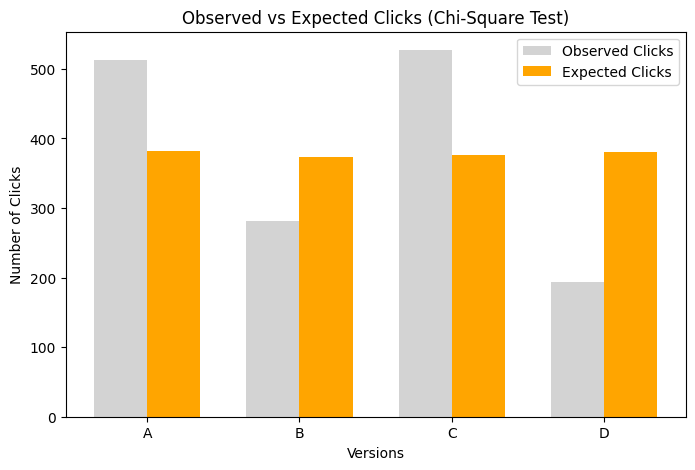

In [140]:
observed_clicks = chi_table.loc["Click"].values
expected_clicks = expected[0]  # row 0 = Click

x = np.arange(len(chi_table.columns))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, observed_clicks, width, label="Observed Clicks", color="lightgray")
plt.bar(x + width/2, expected_clicks, width, label="Expected Clicks", color="orange")
plt.xticks(x, chi_table.columns)
plt.xlabel("Versions")
plt.ylabel("Number of Clicks")
plt.title("Observed vs Expected Clicks (Chi-Square Test)")
plt.legend()
plt.show()
